In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import pylab as pl
from vqr.data import generate_mvn_data, generate_heart, generate_star

d = 2
n = 2000
T = 50

dataset = 'star'

if dataset == 'mvn':
    X, Y = generate_mvn_data(n=n, d=d, k=0)
elif dataset == 'heart':
    X, Y = generate_heart()
elif dataset == 'star':
    X, Y = generate_star()
else:
    X, Y = None, None
    NotImplementedError("Unrecognized dataset.")

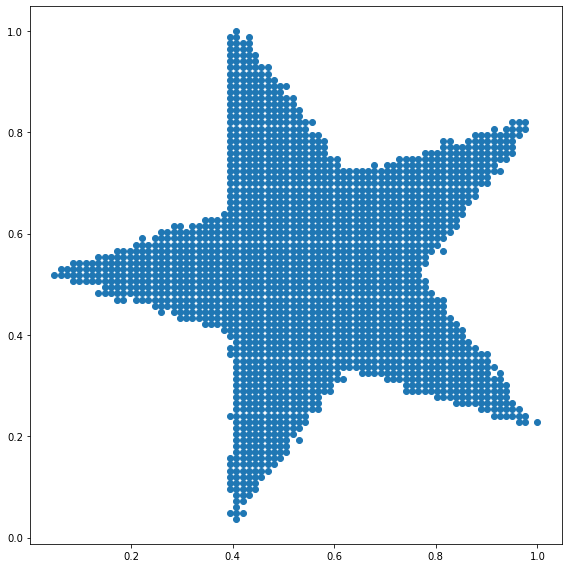

In [2]:
fig = plt.figure(figsize=(8, 8))
plt.scatter(Y[:, 0], Y[:, 1])
# _ = plt.title("Y")
plt.tight_layout()
fig.savefig(f"{dataset}_Y.png")

In [3]:
from vqr.api import VectorQuantileEstimator

T = 50
vqe = VectorQuantileEstimator(T)
fitted_vqe = vqe.fit(Y)

<ipython-input-4-9c183030743c>:2: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


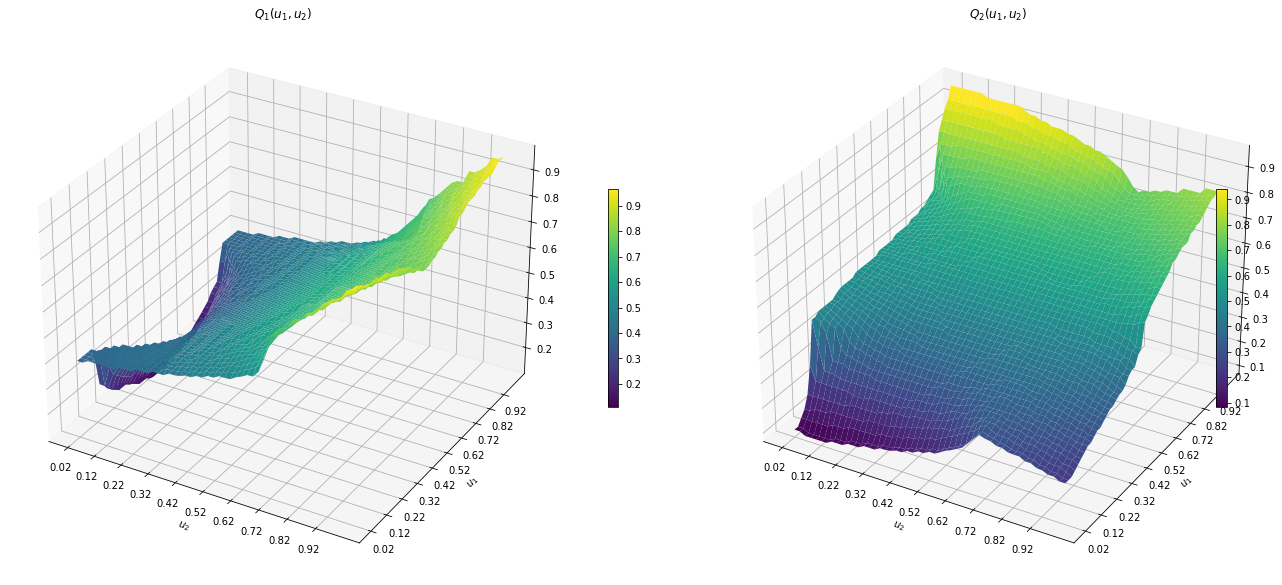

In [4]:
fig = fitted_vqe.plot_quantiles(figsize=(20, 20), surf_2d=True)
plt.tight_layout()
fig.savefig(f"{dataset}_quantile_surfaces_plot.png")

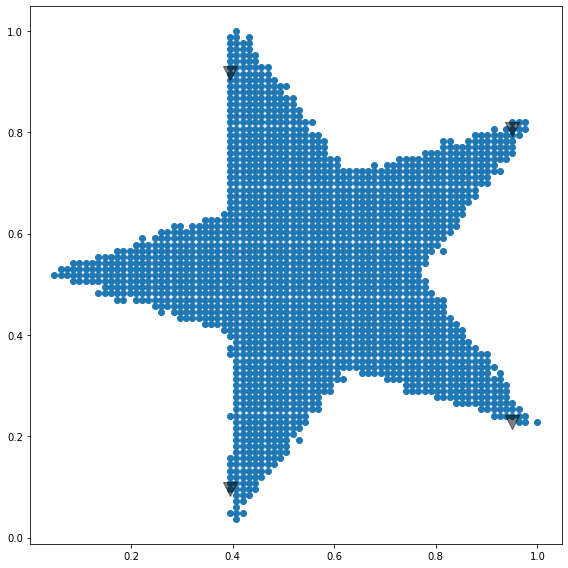

In [5]:
Q1, Q2 = vqe.vector_quantiles()
q_10_90 = [Q1[ 1, -2], Q2[ 1, -2]]
q_90_90 = [Q1[-2, -2], Q2[-2, -2]]
q_90_10 = [Q1[-2,  1], Q2[-2,  1]]
q_10_10 = [Q1[ 1,  1], Q2[ 1,  1]]

fig = plt.figure(figsize=(8, 8))
plt.scatter(Y[:, 0], Y[:, 1])
plt.scatter(q_10_90[0], q_10_90[1], alpha=.5, color='k', s=200, marker='v')
plt.scatter(q_90_90[0], q_90_90[1], alpha=.5, color='k', s=200, marker='v')
plt.scatter(q_90_10[0], q_90_10[1], alpha=.5, color='k', s=200, marker='v')
_ = plt.scatter(q_10_10[0], q_10_10[1], alpha=.5, color='k', s=200, marker='v')
plt.tight_layout()
fig.savefig(f"{dataset}_vector_quantiles_on_Y.png")

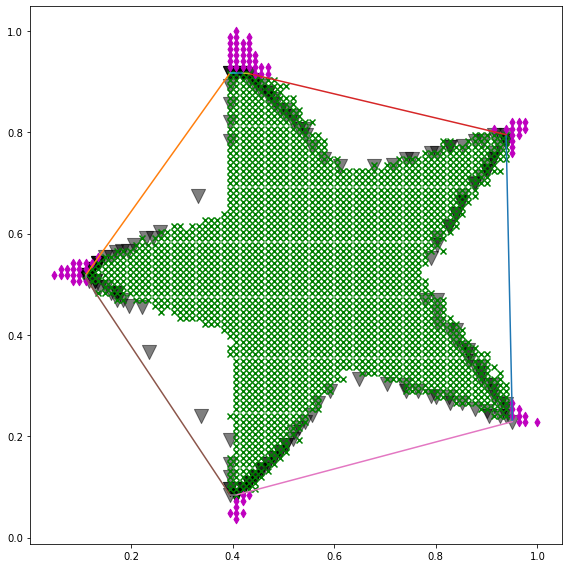

In [6]:
from scipy.spatial import ConvexHull

surface = np.array(
    [
        [*Q1[1:-2, -2], *Q1[1, 1:-2], *Q1[1:-2, 1], *Q1[-2, 1:-2]],
        [*Q2[1:-2, -2], *Q2[1, 1:-2], *Q2[1:-2, 1], *Q2[-2, 1:-2]]
    ]
).T

def point_in_hull(point, hull, tolerance=1e-12):
    return all(
        (np.dot(eq[:-1], point) + eq[-1] <= tolerance)
        for eq in hull.equations)

selected_Y = surface
hull = ConvexHull(selected_Y)

fig = plt.figure(figsize=(8, 8))
for simplex in hull.simplices:
    plt.plot(selected_Y[simplex, 0], selected_Y[simplex, 1])
    
plt.scatter(*selected_Y.T, alpha=.5, color='k', s=200, marker='v')

coverage = []
for p in Y:
    point_is_in_hull = point_in_hull(p, hull)
    coverage.append(point_is_in_hull)
    marker = 'x' if point_is_in_hull else 'd'
    color = 'g' if point_is_in_hull else 'm'
    plt.scatter(p[0], p[1], marker=marker, color=color)
plt.tight_layout()
fig.savefig(f"{dataset}_Y_inliers_outliers_vector.png")

In [7]:
coverage_final = (sum(coverage)/len(coverage))*100
print(f"Coverage for vector quantiles: {coverage_final}.")

Coverage for vector quantiles: 96.27757352941177.


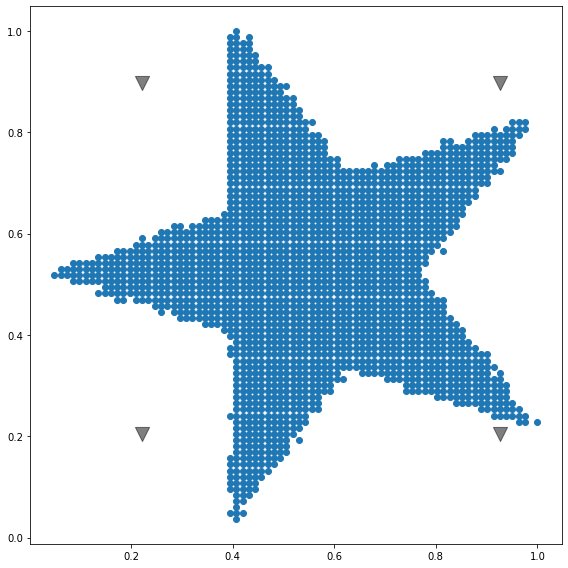

In [8]:
from vqr.api import ScalarQuantileEstimator
sqe = ScalarQuantileEstimator(T)
fitted_sqe = sqe.fit(Y)
Q = fitted_sqe.vector_quantiles()
Q1_sep = Q[:, 0]
Q2_sep = Q[:, 1]

q_10_90 = [Q1_sep[1] , Q2_sep[-2]]
q_90_90 = [Q1_sep[-2], Q2_sep[-2]]
q_90_10 = [Q1_sep[-2], Q2_sep[ 1]]
q_10_10 = [Q1_sep[ 1], Q2_sep[ 1]]

fig = plt.figure(figsize=(8, 8))
plt.scatter(Y[:, 0], Y[:, 1])
plt.scatter(q_10_90[0], q_10_90[1], alpha=.5, color='k', s=200, marker='v')
plt.scatter(q_90_90[0], q_90_90[1], alpha=.5, color='k', s=200, marker='v')
plt.scatter(q_90_10[0], q_90_10[1], alpha=.5, color='k', s=200, marker='v')
plt.scatter(q_10_10[0], q_10_10[1], alpha=.5, color='k', s=200, marker='v')
plt.tight_layout()
fig.savefig(f"{dataset}_separable_quantiles_on_Y.png")

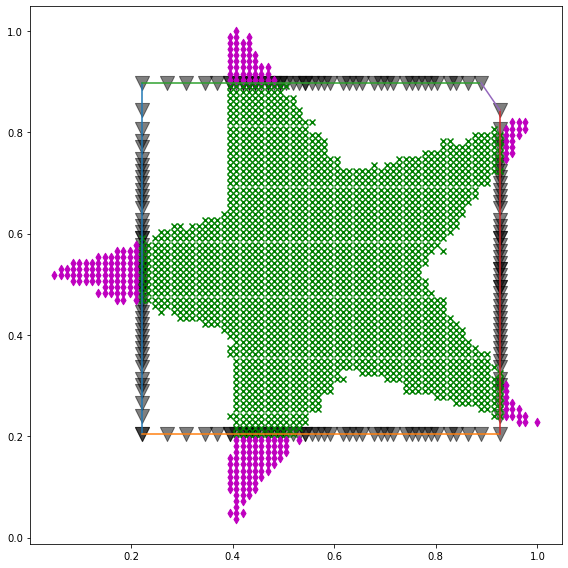

In [9]:
from scipy.spatial import ConvexHull

surface_sep = np.array(
    [
        [
            *Q1_sep[1:-2],
            *Q1_sep[1:-2], 
            *[Q1_sep[ 1]]*len(Q2_sep[1:-2]),
            *[Q1_sep[-2]]*len(Q2_sep[1:-2]),
        ],

        [
            *[Q2_sep[-2]]*len(Q1_sep[1:-2]),
            *[Q2_sep[1]]*len(Q1_sep[1:-2]), 
            *Q2_sep[1:-2], 
            *Q2_sep[1:-2]
        ]
                    
    ]
).T


selected_Y = surface_sep
hull = ConvexHull(selected_Y)
fig = plt.figure(figsize=(8, 8))
for simplex in hull.simplices:
    plt.plot(selected_Y[simplex, 0], selected_Y[simplex, 1])
    
plt.scatter(*selected_Y.T, alpha=.5, color='k', s=200, marker='v')

coverage_sep = []
for p in Y:
    point_is_in_hull = point_in_hull(p, hull)
    coverage_sep.append(point_is_in_hull)
    marker = 'x' if point_is_in_hull else 'd'
    color = 'g' if point_is_in_hull else 'm'
    plt.scatter(p[0], p[1], marker=marker, color=color)
plt.tight_layout()
fig.savefig(f"{dataset}_Y_inliers_outliers_separable.png")

In [10]:
coverage_sep_final = (sum(coverage_sep)/len(coverage_sep))*100
print(f"Coverage for separable quantiles: {coverage_sep_final}.")

Coverage for separable quantiles: 89.38419117647058.


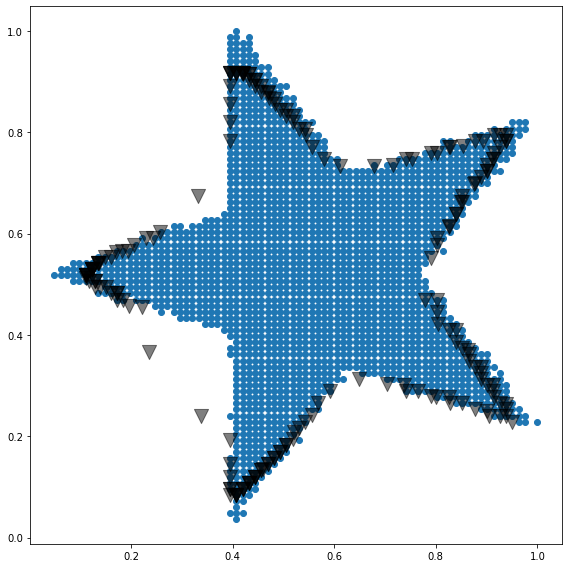

In [11]:
fig = plt.figure(figsize=(8, 8))
plt.scatter(Y[:, 0], Y[:, 1])
plt.scatter(Q1[1:-2, -2], Q2[1:-2, -2], alpha=.5, color='k', s=200, marker='v')
plt.scatter(Q1[1,  1:-2], Q2[1, 1: -2], alpha=.5, color='k', s=200, marker='v')
plt.scatter(Q1[1:-2,  1], Q2[1:-2,  1], alpha=.5, color='k', s=200, marker='v')
plt.scatter(Q1[-2, 1:-2], Q2[-2, 1:-2], alpha=.5, color='k', s=200, marker='v')
# _ = plt.title(f"Vector quantile surface of Y. Coverage of cvx hull: {coverage_final}")
plt.tight_layout()
fig.savefig(f"{dataset}_vector_quantile_surface_on_Y.png")

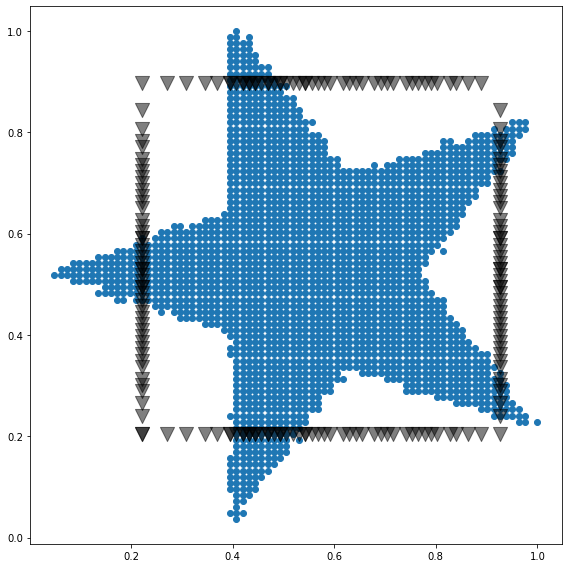

In [12]:
fig = plt.figure(figsize=(8, 8))

plt.scatter(Y[:, 0], Y[:, 1])
plt.scatter(Q1_sep[1:-2], [Q2_sep[-2]]*len(Q1_sep[1:-2]), alpha=.5, color='k', s=200, marker='v')
plt.scatter(Q1_sep[1:-2], [Q2_sep[1]]*len(Q1_sep[1:-2]), alpha=.5, color='k', s=200, marker='v')
plt.scatter([Q1_sep[ 1]]*len(Q2_sep[1:-2]), Q2_sep[1:-2], alpha=.5, color='k', s=200, marker='v')
plt.scatter([Q1_sep[-2]]*len(Q2_sep[1:-2]), Q2_sep[1:-2], alpha=.5, color='k', s=200, marker='v')
# _ = plt.title(f"Separable quantile surface of Y. Coverage of cvx hull: {coverage_sep_final}")
plt.tight_layout()
fig.savefig(f"{dataset}_separable_quantile_surface_on_Y.png")

In [13]:
print(coverage_final, coverage_sep_final)

96.27757352941177 89.38419117647058
